In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Forces TensorFlow to use CPU
import pandas as pd
from mtcnn import MTCNN
import cv2
import numpy as np
from multiprocessing import Pool
import matplotlib.pyplot as plt

2023-12-01 04:14:15.469778: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 AVX_VNNI AMX_TILE AMX_INT8 AMX_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 04:14:17.435627: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# pip install --upgrade tensorflow mtcnn

# Step 3: Data Preprocessing

#### 3a: Extract Labels from filename

In [3]:
def extract_labels(file_name):
    """
    Extracts age, gender, and race from the file name.
    """
    parts = file_name.split('_')
    if len(parts) >= 4:
        try:
            age = int(parts[0])
            gender = int(parts[1])
            race = int(parts[2])
            return age, gender, race
        except ValueError:
            # Handles any conversion errors
            return None, None, None
    return None, None, None

# Path to the UTKFace dataset
utkface_path = 'UTKFaces/'

# List to hold the data
data = []

# Loop through the images in the dataset
for folder_name in ['part1', 'part2', 'part3']:
    folder_path = os.path.join(utkface_path, folder_name)
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.jpg'):
            age, gender, race = extract_labels(file_name)
            if age is not None and gender is not None and race is not None:
                data.append([file_name, age, gender, race])

# Create a DataFrame
df = pd.DataFrame(data, columns=['FileName', 'Age', 'Gender', 'Race'])

# Display the first few rows
print(df.head())

                       FileName  Age  Gender  Race
0  17_0_2_20170105183335071.jpg   17       0     2
1  72_0_0_20170111195358992.jpg   72       0     0
2   8_0_0_20170110215342047.jpg    8       0     0
3  69_0_0_20170104184837071.jpg   69       0     0
4   8_1_0_20170109203450522.jpg    8       1     0


In [4]:
# pip install mtcnn

#### 3b: Loading and Preprocessing Images

#### Full Script Using Haar Cascade for Face Detection

In [5]:
def process_image(file_path):
    """
    Processes the image using Haar Cascade: detect face, resize, and normalize.
    """
    # Load image
    image = cv2.imread(file_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load Haar cascade
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

    # Detect faces
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    for (x, y, w, h) in faces:
        # Extract the face
        face = image[y:y+h, x:x+w]

        # Resize face to 128x128
        face = cv2.resize(face, (128, 128))

        # Normalize pixel values
        face = face.astype('float32')
        face /= 255.0

        return face

def process_image_wrapper(file_path):
    return process_image(file_path)

def process_all_images(folder_path):
    files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.jpg')]
    with Pool(processes=os.cpu_count()) as pool:
        results = pool.map(process_image_wrapper, files)
    return results

# empty list to hold all processed faces 
all_processed_faces = []

# Process each folder and append results to the master list
for folder_name in ['part1', 'part2', 'part3']:
    folder_path = os.path.join(utkface_path, folder_name)
    processed_faces = process_all_images(folder_path)
    all_processed_faces.extend(processed_faces)

Corrupt JPEG data: premature end of data segment
libpng warning: iCCP: known incorrect sRGB profile
Corrupt JPEG data: bad Huffman code


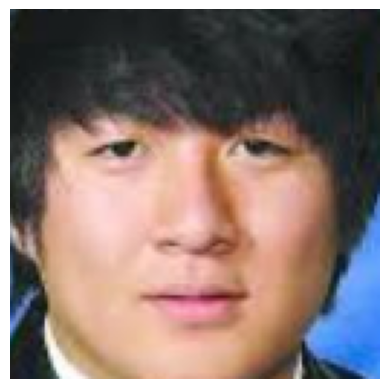

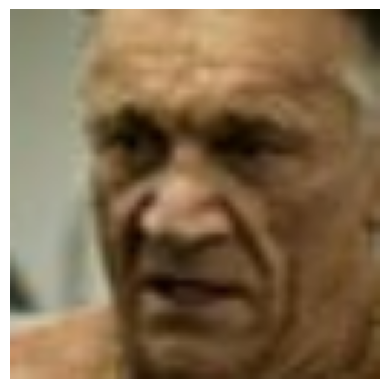

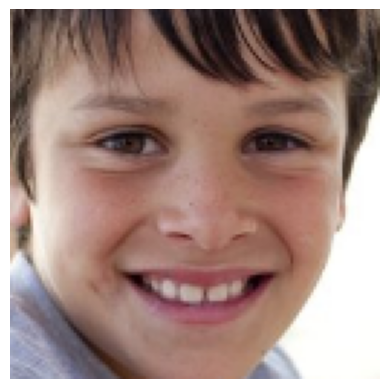

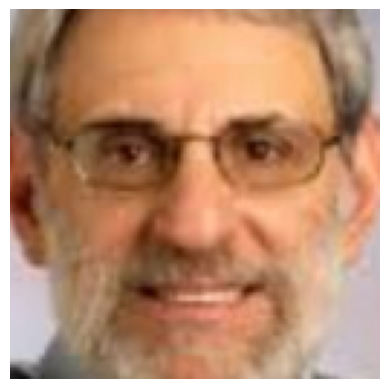

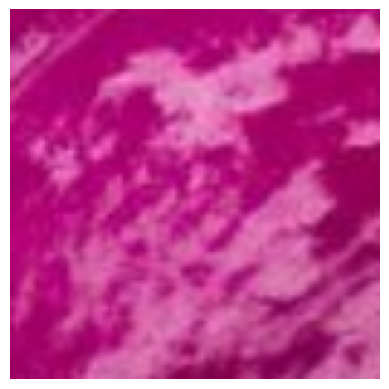

In [6]:
# Function to display image
def display_image(image):
    plt.imshow(image)
    plt.axis('off')  # Turn off axis numbers
    plt.show()

# Display the first few images
num_images_to_display = 5 

for i in range(num_images_to_display):
    display_image(all_processed_faces[i])

In [13]:
# Extract Labels from DataFrame
ages = df['Age'].tolist()
genders = df['Gender'].tolist()

In [14]:
# Trim all_processed_faces to match the length of ages and genders
all_processed_faces = all_processed_faces[:len(ages)]

print(f"Length of processed images after trimming: {len(all_processed_faces)}")

Length of processed images after trimming: 24102


### Data Splitting

In [11]:
from sklearn.model_selection import train_test_split

In [15]:
# Splitting data into train and test (70% train, 30% for validation and test)
X_train, X_temp, y_train_age, y_temp_age, y_train_gender, y_temp_gender = train_test_split(
    all_processed_faces, ages, genders, test_size=0.3, random_state=42)

# Splitting the 30% into validation and test sets (15% each)
X_val, X_test, y_val_age, y_test_age, y_val_gender, y_test_gender = train_test_split(
    X_temp, y_temp_age, y_temp_gender, test_size=0.5, random_state=42)

# Step 4: Model Selection

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [17]:
# CNN architecture for gender prediction
def build_gender_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
# CNN architecture for age prediction
def build_age_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')  # Output a single value for age
    ])
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model


#### Filter Out None Entries

In [21]:
def filter_images_and_labels(images, labels):
    filtered_images = []
    filtered_labels = []
    for img, label in zip(images, labels):
        if img is not None:
            filtered_images.append(img)
            filtered_labels.append(label)
    return filtered_images, filtered_labels

# Apply the filtering
X_train, y_train_age = filter_images_and_labels(X_train, y_train_age)
X_train, y_train_gender = filter_images_and_labels(X_train, y_train_gender)

X_val, y_val_age = filter_images_and_labels(X_val, y_val_age)
X_val, y_val_gender = filter_images_and_labels(X_val, y_val_gender)

X_test, y_test_age = filter_images_and_labels(X_test, y_test_age)
X_test, y_test_gender = filter_images_and_labels(X_test, y_test_gender)

In [22]:
# 
for img_set in [X_train, X_val, X_test]:
    for img in img_set[:5]:  # 
        print(img.shape)


(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)
(128, 128, 3)


### Convert to NumPy Arrays

In [25]:
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

# convert labels to NumPy arrays
y_train_age = np.array(y_train_age)
y_train_gender = np.array(y_train_gender)
y_val_age = np.array(y_val_age)
y_val_gender = np.array(y_val_gender)
y_test_age = np.array(y_test_age)
y_test_gender = np.array(y_test_gender)

### Training the Models

In [ ]:
# train the gender model
gender_model = build_gender_model(input_shape)
gender_model.fit(X_train, np.array(y_train_gender), validation_data=(X_val, np.array(y_val_gender)), epochs=10)

# train the age model
age_model = build_age_model(input_shape)
age_model.fit(X_train, np.array(y_train_age), validation_data=(X_val, np.array(y_val_age)), epochs=10)
